In [1]:
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import time, random, os
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)
!python --version

2.8.0
Python 3.8.10


In [3]:
class Episode_experience():
    def __init__(self):
        self.memory = []

    def add(self, state, action, reward, next_state, done, goal):
        self.memory += [(state, action, reward, next_state, done, goal)]

    def clear(self):
        self.memory = []

class DDPGAgent:
    def __init__(self, state_size, action_size, goal_size, action_low=-1, action_high=1, gamma=0.98,
                 actor_learning_rate=0.01, critic_learning_rate=0.01, tau=1e-3):
        self.state_size = state_size
        self.action_size = action_size
        self.goal_size = goal_size
        self.action_low = action_low
        self.action_high = action_high
        self.gamma = gamma   # discount rate
        self.memory = []
        self.buffer_size = int(5e4)
        self.a_learning_rate = actor_learning_rate
        self.c_learning_rate = critic_learning_rate # often larger than actor_learning_rate
        self.tau = tau # soft update
        self.batch_size = 32
        self.gradient_norm_clip = None
        self._construct_nets()

    def _construct_nets(self):
        tf.compat.v1.reset_default_graph()
        self.sess = tf.compat.v1.Session()

        self.S = tf.compat.v1.placeholder(tf.float32, [None, self.state_size], 'state')
        self.S_ = tf.compat.v1.placeholder(tf.float32, [None, self.state_size], 'next_state')
        self.G = tf.compat.v1.placeholder(tf.float32, [None, self.goal_size], 'goal')
        self.D = tf.compat.v1.placeholder(tf.float32, [None, 1], 'done')
        self.R = tf.compat.v1.placeholder(tf.float32, [None, 1], 'r')

        with tf.compat.v1.variable_scope('Actor'):
            self.a = self._build_a(self.S, self.G, scope='eval')
            self.a_ = self._build_a(self.S_, self.G, scope='target')
        with tf.compat.v1.variable_scope('Critic'):
            self.q = self._build_c(self.S, self.a, self.G, scope='eval')
            self.q_ = self._build_c(self.S_, self.a_, self.G, scope='target')

        self.ae_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        self.soft_update_op = [[tf.compat.v1.assign(ta, (1 - self.tau) * ta + self.tau * ea), 
                                tf.compat.v1.assign(tc, (1 - self.tau) * tc + self.tau * ec)]
                    for ta, ea, tc, ec in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]

        q_target = self.R + self.gamma * (1-self.D) * self.q_
#         q_target = tf.clip_by_value(q_target, -1/(1-self.gamma), 0)

        self.c_loss = tf.compat.v1.losses.mean_squared_error(q_target, self.q)
        self.a_loss = - tf.reduce_mean(input_tensor=self.q)    # maximize the q

        if self.gradient_norm_clip is not None:
            c_optimizer = tf.compat.v1.train.AdamOptimizer(self.c_learning_rate)
            c_gradients = c_optimizer.compute_gradients(self.c_loss, var_list=self.ce_params)
            for i, (grad, var) in enumerate(c_gradients):
                if grad is not None:
                    c_gradients[i] = (tf.clip_by_norm(grad, self.gradient_norm_clip), var)
            self.c_train = c_optimizer.apply_gradients(c_gradients)
            a_optimizer = tf.compat.v1.train.AdamOptimizer(self.a_learning_rate)
            a_gradients = c_optimizer.compute_gradients(self.a_loss, var_list=self.ae_params)
            for i, (grad, var) in enumerate(a_gradients):
                if grad is not None:
                    a_gradients[i] = (tf.clip_by_norm(grad, self.gradient_norm_clip), var)
            self.a_train = a_optimizer.apply_gradients(a_gradients)
        else:
            self.c_train = tf.compat.v1.train.AdamOptimizer(self.c_learning_rate).minimize(self.c_loss, var_list=self.ce_params)
            self.a_train = tf.compat.v1.train.AdamOptimizer(self.a_learning_rate).minimize(self.a_loss, var_list=self.ae_params)

        self.saver = tf.compat.v1.train.Saver()
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def _build_a(self, s, g, scope): # policy
        with tf.compat.v1.variable_scope(scope):
            net = tf.concat([s, g], 1)
            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            a = tf.compat.v1.layers.dense(net, self.action_size, tf.nn.tanh)
            result = a * (self.action_high-self.action_low)/2 + (self.action_high+self.action_low)/2
            return result

    def _build_c(self, s, a, g, scope): # Q value
        with tf.compat.v1.variable_scope(scope):
            net = tf.concat([s, a, g], 1)
            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
            return tf.compat.v1.layers.dense(net, 1)

    def choose_action(self, state, goal, variance): # normal distribution
        action = self.sess.run(self.a, {self.S: state, self.G: goal})[0]
        return np.clip(np.random.normal(action, variance), self.action_low, self.action_high)

    def remember(self, ep_experience):
        self.memory += ep_experience.memory
        if len(self.memory) > self.buffer_size:
            self.memory = self.memory[-self.buffer_size:] # empty the first memories

    def replay(self, optimization_steps=1):
        if len(self.memory) < self.batch_size: # if there's no enough transitions, do nothing
            return 0, 0

        a_losses = 0
        c_losses = 0
        for _ in range(optimization_steps):
            minibatch = np.vstack(random.sample(self.memory, self.batch_size))
            ss = np.vstack(minibatch[:,0])
            acs = np.vstack(minibatch[:,1])
            rs = np.vstack(minibatch[:,2])
            nss = np.vstack(minibatch[:,3])
            ds = np.vstack(minibatch[:,4])
            gs = np.vstack(minibatch[:,5])
            a_loss, _ = self.sess.run([self.a_loss, self.a_train],
                                      {self.S: ss, self.G: gs})
            c_loss, _ = self.sess.run([self.c_loss, self.c_train],
                                      {self.S: ss, self.a: acs, self.R: rs,
                                       self.S_: nss, self.D: ds, self.G: gs})
            a_losses += a_loss
            c_losses += c_loss

        return a_losses/optimization_steps, c_losses/optimization_steps

    def update_target_net(self):
        self.sess.run(self.soft_update_op)

In [4]:
env_name = "TouchCube"
    
try:
    env.close()
except:
    pass

from mlagents_envs.environment import UnityEnvironment

env = UnityEnvironment(file_name=env_name)
env.reset()

[INFO] Connected to Unity environment with package version 1.2.0-preview and communication version 1.0.0


INFO:mlagents_envs.environment:Connected to Unity environment with package version 1.2.0-preview and communication version 1.0.0


[INFO] Connected new brain: TouchCube?team=0


INFO:mlagents_envs.environment:Connected new brain: TouchCube?team=0


In [5]:
brain_name = list(env.behavior_specs)[0]#env.brain_names[0]
brain = env.behavior_specs[brain_name]#env.brains[brain_name]
decision_steps, terminal_steps = env.get_steps(brain_name)
# Note : len(decision_steps) = [number of agents that requested a decision]

num_agents = len(decision_steps)
print("num agents ", num_agents)

if brain.action_spec.discrete_size > 0:
    for action, branch_size in enumerate(brain.action_spec.discrete_branches):
        print(f"Action number {action} has {branch_size} different options")
        state_size = branch_size

action_size = brain.action_spec.continuous_size
print("action size ", action_size)

decision_steps, terminal_steps = env.get_steps(brain_name)
state_size = len(decision_steps.obs[0][0])
print("state size ", state_size)

print("Agent state looks like: \n{}".format(decision_steps.obs[0]))

num agents  1
action size  3
state size  15
Agent state looks like: 
[[ 0.2430497   0.          0.37310985  0.2430497  -0.83987963  0.37310985
   0.          0.83987963  0.          0.          0.          0.
   0.          0.          0.        ]]


In [6]:
def reward_func(state, goal):
    hand = state[3:6]
    dist = np.linalg.norm(hand-goal)*5 # range=5
    done = False
    reward = -1
    if dist<=1:
        done = True
        reward = 1
    return done, reward

# DDPG agent

In [7]:
agent = DDPGAgent(state_size= state_size - 3, action_size=action_size, goal_size=3, action_high=3,
                  action_low=-3, actor_learning_rate=1e-3, critic_learning_rate=1e-3,
                  tau=0.1
                 )
variance=5

C:\Users\vika9\AppData\Local\Temp\ipykernel_12120\1521190820.py:84: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\vika9\AppData\Local\Temp\ipykernel_12120\1521190820.py:85: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
C:\Users\vika9\AppData\Local\Temp\ipykernel_12120\1521190820.py:86: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense

## With HER

In [8]:
#set_global_determinism(seed=SEED)
#env.rng = np.random.default_rng(seed=SEED)
use_her = True # use hindsight experience replay or not
num_epochs = 100
num_episodes = 20 # number of episodes over which success rate is computed
episode_length = 500
optimization_steps = 40
K = 8 # number of random future states

a_losses = []
c_losses = []
ep_mean_r = []
success_rate = []

ep_experience = Episode_experience()
ep_experience_her = Episode_experience()

start = time.process_time()
total_step = 0
for i in range(num_epochs):
    successes = 0
    ep_total_r = 0
    for n in range(num_episodes):
        
        env.reset()
        brain_name = list(env.behavior_specs)[0]
        brain = env.behavior_specs[brain_name]
        decision_steps, terminal_steps = env.get_steps(brain_name)
        
        state = decision_steps.obs[0][0][3:]
        goal = decision_steps.obs[0][0][:3]
        
        for ep_step in range(episode_length):
            total_step += 1
            action = agent.choose_action([state], [goal], variance)
            
            #print("action ",action) # -- [ 1.         -0.81721041 -1.          1.        ]
            #print("env_action.continuous ", env_action.continuous) # -- [[-0.739338 -0.739338 -0.739338 -0.739338]]
            
            env_action = brain.action_spec.random_action(len(decision_steps))
            for j in range(len(action)):
                env_action.continuous[0][j] = action[j]
            
            env.set_actions(brain_name, env_action)
            env.step()
            decision_steps, terminal_steps = env.get_steps(brain_name)
            
            for agent_id_decisions in decision_steps:
                next_state = decision_steps.obs[0][0][3:]
            for agent_id_terminated in terminal_steps:
                next_state = terminal_steps.obs[0][0][3:]
            
            for agent_id_decisions in decision_steps:
                reward = decision_steps.reward[0]
            for agent_id_terminated in terminal_steps:
                reward = terminal_steps.reward[0]
            
            dones = terminal_steps.interrupted
            done=False
            if (len(dones) > 0):
                done = True
            else:
                done=False         
            
            ep_total_r += reward
            ep_experience.add(state, action, reward, next_state, done, goal)
            state = next_state
            if total_step % 200 == 0 or done:
                if use_her: # The strategy can be changed here
                    for t in range(len(ep_experience.memory)):
                        for _ in range(K):
                            future = np.random.randint(t, len(ep_experience.memory))
                            goal_ = ep_experience.memory[future][3][3:6] # next_state of future
                            state_ = ep_experience.memory[t][0]
                            action_ = ep_experience.memory[t][1]
                            next_state_ = ep_experience.memory[t][3]
                            done_, reward_ = reward_func(next_state_, goal_)
                            ep_experience_her.add(state_, action_, reward_, next_state_, done_, goal_)
                    agent.remember(ep_experience_her)
                    ep_experience_her.clear()
                agent.remember(ep_experience)
                ep_experience.clear()
                variance *= 0.9995
                a_loss, c_loss = agent.replay(optimization_steps)
                a_losses += [a_loss]
                c_losses += [c_loss]
                agent.update_target_net()
            if done:
                break
        successes += reward>=0 and done

    success_rate.append(successes/num_episodes)
    ep_mean_r.append(ep_total_r/num_episodes)
    print("\repoch", i+1, "success rate %.2f"%success_rate[-1], "ep_mean_r %.2f"%ep_mean_r[-1], 'exploration %.2f'%variance, end=' '*10)

print("Training time : %.2f"%(time.process_time()-start), "s")

c:\users\vika9\appdata\local\programs\python\python38\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


epoch 100 success rate 1.00 ep_mean_r -1.15 exploration 1.64          Training time : 503.95 s


In [9]:
agent.saver.save(agent.sess, "model/old_hand_hands3_step3_her.ckpt");

## Without HER

In [10]:
agent = DDPGAgent(state_size= state_size - 3, action_size=action_size, goal_size=3, action_high=3,
                  action_low=-3, actor_learning_rate=1e-3, critic_learning_rate=1e-3,
                  tau=0.1
                 )
variance=5

C:\Users\vika9\AppData\Local\Temp\ipykernel_18632\1521190820.py:84: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
C:\Users\vika9\AppData\Local\Temp\ipykernel_18632\1521190820.py:85: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
C:\Users\vika9\AppData\Local\Temp\ipykernel_18632\1521190820.py:86: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  net = tf.compat.v1.layers.dense(net, 64, tf.nn.relu)
C:\Users\vika9\AppData\Local\Temp\ipykernel_18632\1521190820.py:87: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  a = tf.compat.v1.layers.dense(net, self.a

In [11]:
num_epochs = 100
num_episodes = 20 # number of episodes over which success rate is computed
episode_length = 500
optimization_steps = 40

a_losses_without_her = []
c_losses_without_her = []
ep_mean_r_without_her = []
success_rate_without_her = []

ep_experience = Episode_experience()

#start = time.clock()
start = time.process_time()

total_step = 0
for i in range(num_epochs):
    successes = 0
    ep_total_r = 0
    for n in range(num_episodes):
        
        #env_info = env.reset(train_mode=True)[default_brain]
        #state = env_info.states[0][3:]
        #goal = env_info.states[0][:3]
        
        env.reset()
        brain_name = list(env.behavior_specs)[0]
        brain = env.behavior_specs[brain_name]
        decision_steps, terminal_steps = env.get_steps(brain_name)
        state = decision_steps.obs[0][0][3:]
        goal = decision_steps.obs[0][0][:3]
        
        for ep_step in range(episode_length):
            total_step += 1
            action = agent.choose_action([state], [goal], variance)
            
            #env_info = env.step(action)[default_brain]
            
            env_action = brain.action_spec.random_action(len(decision_steps))
            for j in range(len(action)):
                env_action.continuous[0][j] = action[j]
            env.set_actions(brain_name, env_action)
            env.step()
            decision_steps, terminal_steps = env.get_steps(brain_name)
            
            #next_state = env_info.states[0][3:]
            #reward = env_info.rewards[0]
            #done = env_info.local_done[0]
            
            for agent_id_decisions in decision_steps:
                next_state = decision_steps.obs[0][0][3:]
            for agent_id_terminated in terminal_steps:
                next_state = terminal_steps.obs[0][0][3:]
            for agent_id_decisions in decision_steps:
                reward = decision_steps.reward[0]
            for agent_id_terminated in terminal_steps:
                reward = terminal_steps.reward[0]
            dones = terminal_steps.interrupted
            done=False
            if (len(dones) > 0):
                done = True
            else:
                done=False         
            
            ep_total_r += reward
            ep_experience.add(state, action, reward, next_state, done, goal)
            state = next_state
            if total_step % 200 == 0 or done:
                agent.remember(ep_experience)
                ep_experience.clear()
                variance *= 0.9995
                a_loss, c_loss = agent.replay(optimization_steps)
                a_losses_without_her += [a_loss]
                c_losses_without_her += [c_loss]
                agent.update_target_net()
            if done:
                break
        successes += reward>=0 and done

    success_rate_without_her.append(successes/num_episodes)
    ep_mean_r_without_her.append(ep_total_r/num_episodes)
    print("\repoch", i+1, "success rate %.2f"%success_rate_without_her[-1], "ep_mean_r %.2f"%ep_mean_r_without_her[-1], 'exploration %.2f'%variance, end=' '*10)

print("Training time : %.2f"%(time.process_time()-start), "s")

epoch 100 success rate 1.00 ep_mean_r 4.80 exploration 1.67          Training time : 448.45 s


In [12]:
agent.saver.save(agent.sess, "model/old_hand_hands3_step3_withoun_her.ckpt");

## Testing

In [8]:
n_episodes = 100

test_rewards = []
agent.saver.restore(agent.sess, "model/old_hand_hands3_step3_withoun_her.ckpt")
for i_episode in range(n_episodes):
    
    env.reset()
        
    brain_name = list(env.behavior_specs)[0]
    brain = env.behavior_specs[brain_name]
    decision_steps, terminal_steps = env.get_steps(brain_name)
    state = decision_steps.obs[0][0][3:]
    goal = decision_steps.obs[0][0][:3]
    
    r = 0
    while True:
        action = agent.choose_action([state], [goal], 0)
        env_action = brain.action_spec.random_action(len(decision_steps))
        for j in range(len(action)):
            env_action.continuous[0][j] = action[j]
        env.set_actions(brain_name, env_action)
        env.step()
                
        decision_steps, terminal_steps = env.get_steps(brain_name)
        
        for agent_id_decisions in decision_steps:
            next_state = decision_steps.obs[0][0][3:]
        for agent_id_terminated in terminal_steps:
            next_state = terminal_steps.obs[0][0][3:]
        for agent_id_decisions in decision_steps:
            reward = decision_steps.reward[0]
        for agent_id_terminated in terminal_steps:
            reward = terminal_steps.reward[0]

        dones = terminal_steps.interrupted
        done=False
        if (len(dones) > 0):
            done = True      
        
        r += reward
        state = next_state
        if done:
            print("episode:", i_episode+1, "rewards: %.2f" % r, end="\r")
            test_rewards += [r]
            break

INFO:tensorflow:Restoring parameters from model/old_hand_hands3_step3_withoun_her.ckpt


INFO:tensorflow:Restoring parameters from model/old_hand_hands3_step3_withoun_her.ckpt


# Plot reward

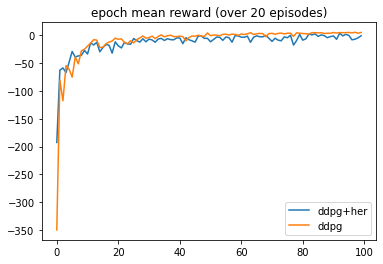

In [13]:
plt.plot(ep_mean_r, label="ddpg+her")
plt.plot(ep_mean_r_without_her, label="ddpg")
plt.legend()
plt.title("epoch mean reward (over 20 episodes)")
plt.show()

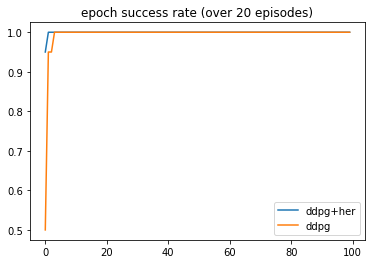

In [14]:
plt.plot(success_rate, label="ddpg+her")
plt.plot(success_rate_without_her, label="ddpg")
plt.legend()
plt.title("epoch success rate (over 20 episodes)")
plt.show()

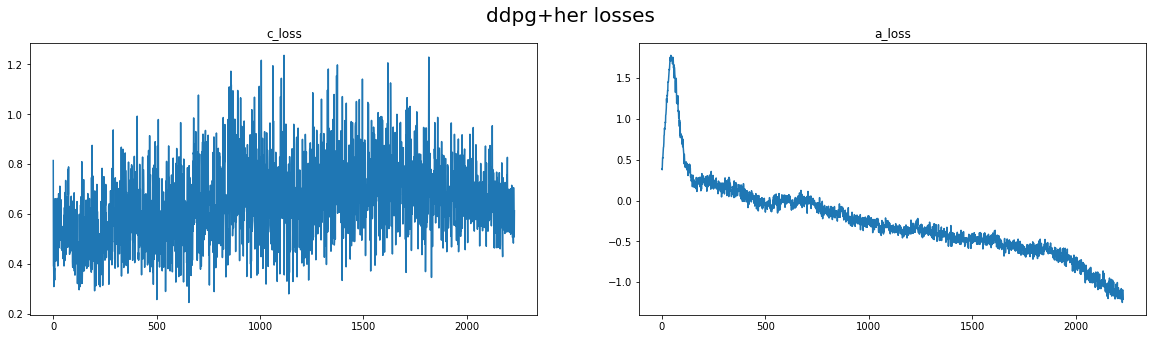

In [15]:
plt.subplots(figsize=(20,5))
plt.suptitle('ddpg+her losses', size=20)
plt.subplot(121)
plt.title('c_loss')
plt.plot(c_losses)
plt.subplot(122)
plt.title('a_loss')
plt.plot(a_losses)
plt.show()

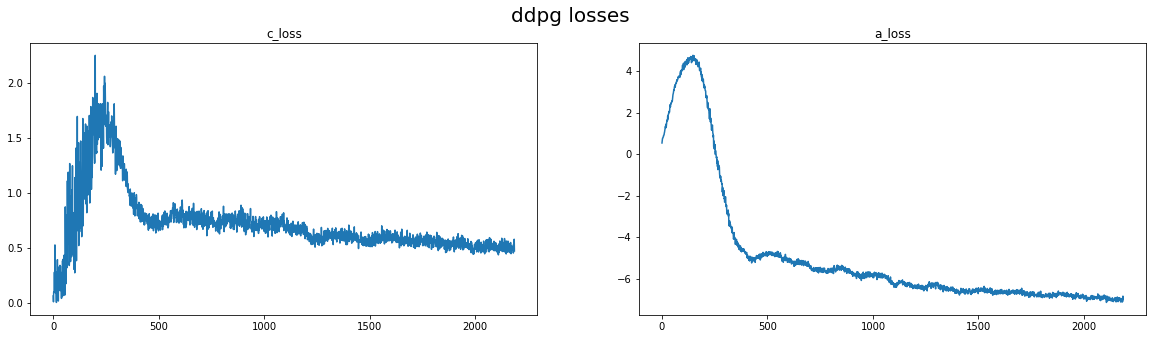

In [16]:
plt.subplots(figsize=(20,5))
plt.suptitle('ddpg losses', size=20)
plt.subplot(121)
plt.title('c_loss')
plt.plot(c_losses_without_her)
plt.subplot(122)
plt.title('a_loss')
plt.plot(a_losses_without_her)
plt.show()

In [17]:
env.close()